# Chapter 4

## Question 10

In [147]:
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots
import numpy as np
import sklearn.linear_model
import sklearn.metrics
import sklearn.discriminant_analysis
import sklearn.neighbors
import pandas as pd

sns.set(style="whitegrid")

In [6]:
# This dataset contains weekly returns for 21 years, from 1990 to 2010.
weekly = sm.datasets.get_rdataset("Weekly", "ISLR").data

### (a) Produce some numerical and graphical summaries of the `weekly` dataset

In [10]:
weekly.describe()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
count,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000
mean,2000.048669,0.150585,0.151079,0.147205,0.145818,0.139893,1.574618,0.149899
std,6.033182,2.357013,2.357254,2.360502,2.360279,2.361285,1.686636,2.356927
min,1990.000000,-18.195000,-18.195000,-18.195000,-18.195000,-18.195000,0.087465,-18.195000
25%,1995.000000,-1.154000,-1.154000,-1.158000,-1.158000,-1.166000,0.332022,-1.154000
50%,2000.000000,0.241000,0.241000,0.241000,0.238000,0.234000,1.002680,0.241000
75%,2005.000000,1.405000,1.409000,1.409000,1.409000,1.405000,2.053727,1.405000
max,2010.000000,12.026000,12.026000,12.026000,12.026000,12.026000,9.328214,12.026000


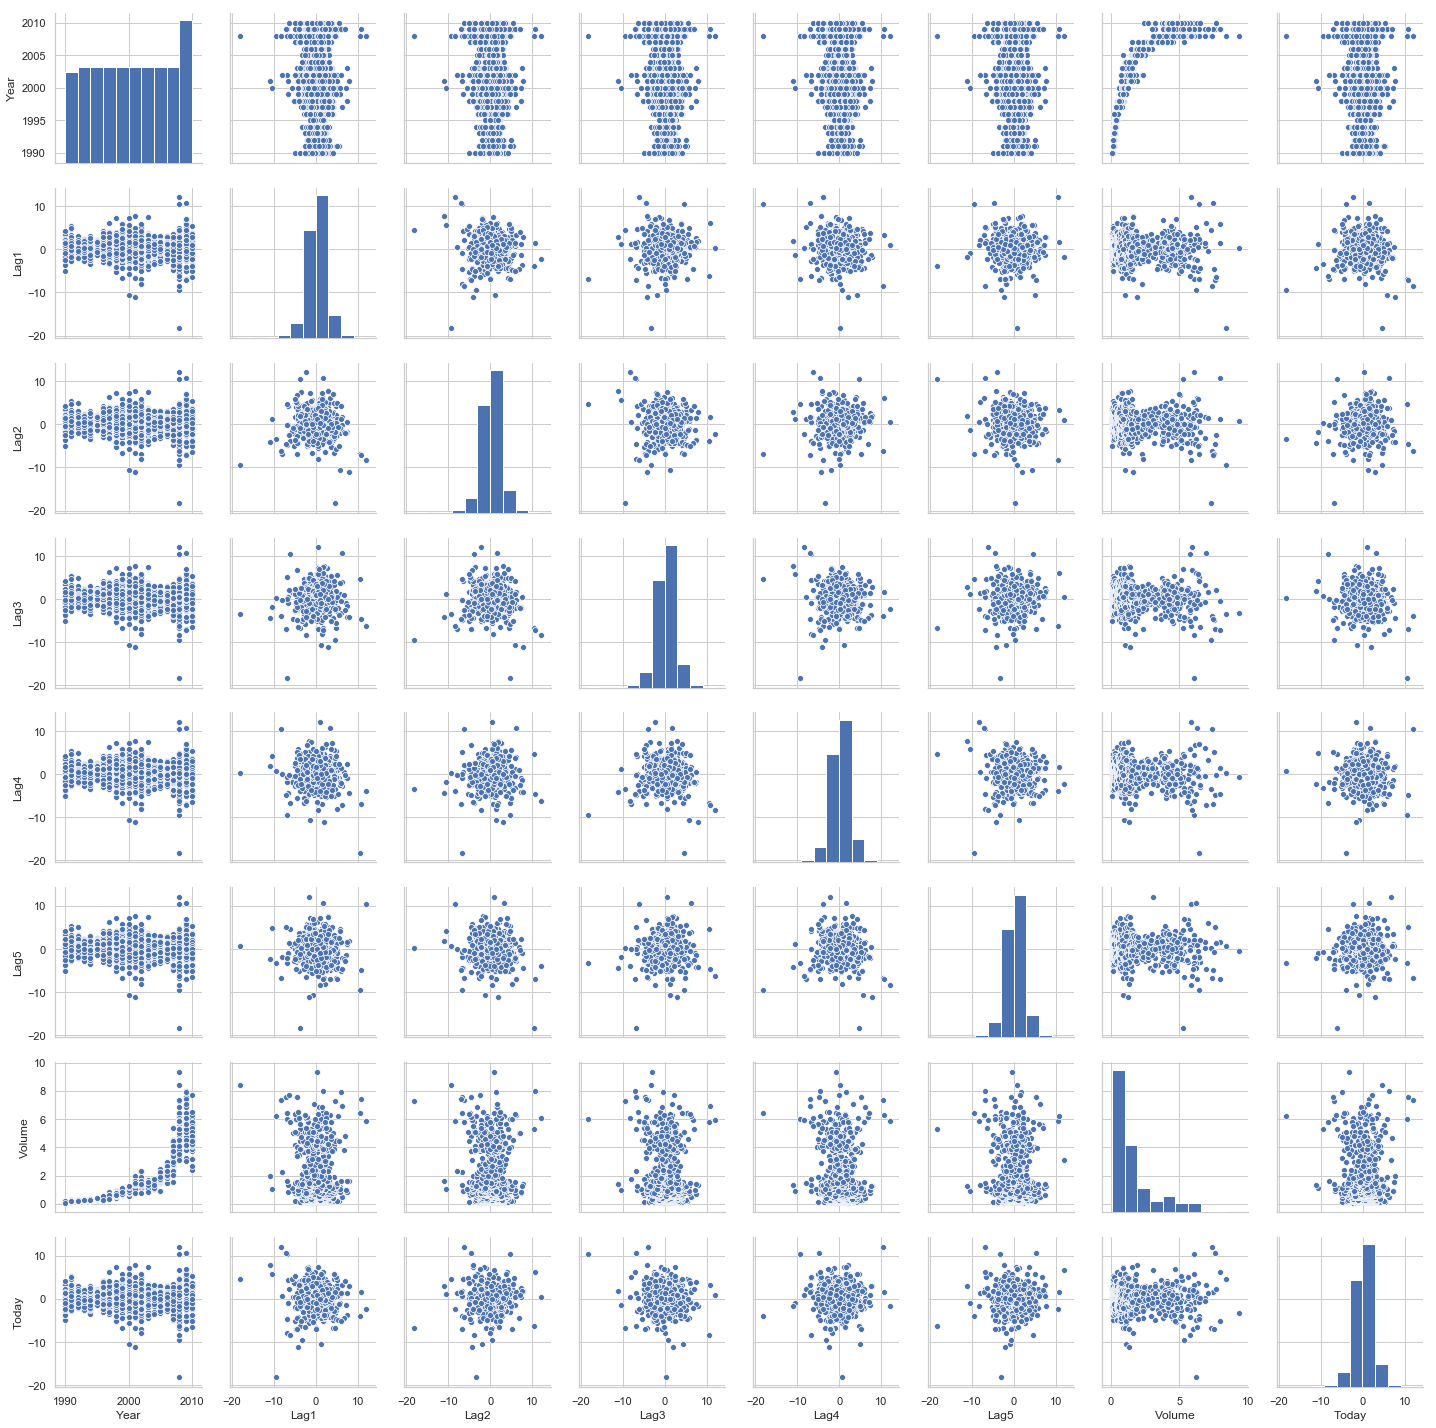

In [23]:
sns.pairplot(weekly)

In [17]:
print(f"Market goes up on average {sum(weekly.Direction=='Up')/len(weekly)*100:.2f}% of the time")

Market goes up on average 55.56% of the time


Patterns:
 - Volume goes steeply up with time
 - Nothing else obvious
 

In [31]:
# Convert this to a time series and do some averages / plots of total change / downsampling?

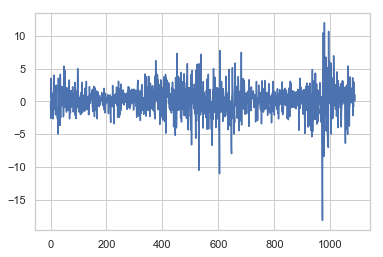

In [22]:
plt.plot(weekly.Today)

In [26]:
# Autocorrelation of the "Today" data

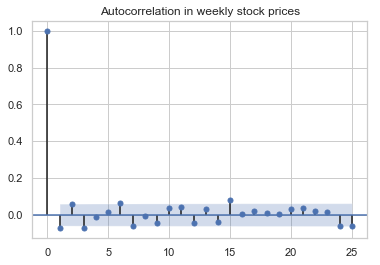

In [30]:
# We don't really expect significant correlation
fig = statsmodels.graphics.tsaplots.plot_acf(weekly.Today, lags=25, title="Autocorrelation in weekly stock prices")

### (b) Use the full data set to perform a logistic regression with `Direction` as the response and the five lag variables plus `Volume` as the predictors.

In [33]:
# Could use sklearn.linear_model.LogisticRegression

In [50]:
y = weekly.Direction=="Up"  # Have to encode this ourselves, apparently. 
X = sm.add_constant(weekly.drop(columns=["Direction","Year","Today"]))
logistic_model =  sm.Logit(y, X)
results = logistic_model.fit()

Optimization terminated successfully.
         Current function value: 0.682441
         Iterations 4


In [51]:
print(results.summary())

                           Logit Regression Results                           
Dep. Variable:              Direction   No. Observations:                 1089
Model:                          Logit   Df Residuals:                     1082
Method:                           MLE   Df Model:                            6
Date:                Wed, 22 May 2019   Pseudo R-squ.:                0.006580
Time:                        14:17:10   Log-Likelihood:                -743.18
converged:                       True   LL-Null:                       -748.10
                                        LLR p-value:                    0.1313
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2669      0.086      3.106      0.002       0.098       0.435
Lag1          -0.0413      0.026     -1.563      0.118      -0.093       0.010
Lag2           0.0584      0.027      2.175      0.0

In [55]:
model = sklearn.linear_model.LogisticRegression()
model.fit(weekly.drop(columns=["Direction","Year","Today"]), weekly.Direction)


/home/will/.local/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [58]:
print(model.intercept_)
print(model.coef_)

[0.26484745]
[[-0.04117292  0.05846974 -0.01599122 -0.02769998 -0.01440289 -0.02212844]]


The two regressors agree, but only the intercept is significant (i.e. there is no-zero probability of "Up" when the lags and volume are all zero). The `Lag2` is significant at a p<0.05 level but needs further investigation, with the Bonferroni correction it wouldn't be.

### (c) compute the confusion matrix and overall fraction of correct predictions

In [63]:
y_true = weekly.Direction
y_pred = model.predict(weekly.drop(columns=["Direction","Year","Today"]))

confusion_matrix = sklearn.metrics.confusion_matrix(y_true, y_pred)
tn, fp, fn, tp = confusion_matrix.ravel()

In [67]:
print(confusion_matrix)
fraction_correct = (tn+tp)/(tn+tp+fn+fp)
print(f"fraction correct: {fraction_correct}")

[[ 55 429]
 [ 47 558]]
fraction correct: 0.5629017447199265


So we are right 56.3% of the time, versus a model that always predicts "Up" which would be right 55.6% of the time. We don't have many false negatives, but we have an awful lot of false positives!

In [82]:
# Check for statsmodels version
y_pred_sm = np.where(results.fittedvalues < 0.5, "Up", "Down")

In [84]:
print(sklearn.metrics.confusion_matrix(y_true, y_pred_sm))


[[ 19 465]
 [ 42 563]]


### (d) Now fit the model using training data from 1990-2008, with `Lag2` as the only predictor. Use the 2009-2010 data as test data, and get the confusion matrix & overall fraction correct.

In [94]:
train = weekly[weekly.Year < 2009]
test = weekly[weekly.Year >= 2009]
x_train = train.Lag2
y_train = train.Direction
x_test = test.Lag2
y_test = test.Direction
model = sklearn.linear_model.LogisticRegression()
model.fit(x_train.to_numpy().reshape(-1,1), y_train) # reshape required to cast the training data to a 2d array
y_pred = model.predict(x_test.to_numpy().reshape(-1,1))

/home/will/.local/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [95]:
confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix.ravel()
print(confusion_matrix)
fraction_correct = (tn+tp)/(tn+tp+fn+fp)
print(f"fraction correct: {fraction_correct}")

[[ 9 34]
 [ 5 56]]
fraction correct: 0.625


### (e) Repeat (d) using LDA

In [98]:
lda_model = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
lda_model.fit(x_train.to_numpy().reshape(-1,1), y_train) # reshape required to cast the training data to a 2d array
y_pred = lda_model.predict(x_test.to_numpy().reshape(-1,1))

confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix.ravel()
print(confusion_matrix)
fraction_correct = (tn+tp)/(tn+tp+fn+fp)
print(f"fraction correct: {fraction_correct}")

[[ 9 34]
 [ 5 56]]
fraction correct: 0.625


### (f) Repeat (d) using QDA

In [101]:
qda_model = sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis()
qda_model.fit(x_train.to_numpy().reshape(-1,1), y_train) # reshape required to cast the training data to a 2d array
y_pred = qda_model.predict(x_test.to_numpy().reshape(-1,1))

confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix.ravel()
print(confusion_matrix)
fraction_correct = (tn+tp)/(tn+tp+fn+fp)
print(f"fraction correct: {fraction_correct}")

[[ 0 43]
 [ 0 61]]
fraction correct: 0.5865384615384616


### (g) Repeat (d) using KNN with K = 1

In [103]:
knn_model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)
knn_model.fit(x_train.to_numpy().reshape(-1,1), y_train) # reshape required to cast the training data to a 2d array
y_pred = knn_model.predict(x_test.to_numpy().reshape(-1,1))

confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix.ravel()
print(confusion_matrix)
fraction_correct = (tn+tp)/(tn+tp+fn+fp)
print(f"fraction correct: {fraction_correct}")

[[21 22]
 [31 30]]
fraction correct: 0.49038461538461536


### (h) Which of these methods appears to provide the best results on this data?

Somewhat surprisingly, it seems like a linear fit performs best on this data, better than QDA and KNN (insinuating that both classes have the same variance in `Lag2`)

### (i) Experiment with different combinations of predictors, including possible transformations and interactions, for each of the methods. Report the best results and parameters.

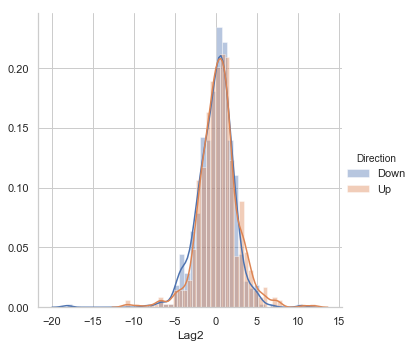

In [112]:
# The p-value for ShelveLoc suggests it is predictive - plot with FacetGrid
# fig, ax = plt.subplots(figsize=(10,10))

g = sns.FacetGrid(weekly, hue="Direction", height=5)
g = g.map(sns.distplot, "Lag2").add_legend()



In [136]:
import itertools

for i in range(1,len(train.columns.drop(["Direction","Year","Today"]))):
    for col in itertools.combinations(train.columns.drop(["Direction","Year","Today"]), i):
        col = list(col)
        print(col)
        x_train = train[col]
        y_train = train.Direction
        x_test = test[col]
        y_test = test.Direction

        lda_model = sklearn.discriminant_analysis.LinearDiscriminantAnalysis()
        lda_model.fit(x_train, y_train) # reshape required to cast the training data to a 2d array
        y_pred = lda_model.predict(x_test)

        confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix.ravel()
        print(confusion_matrix)
        fraction_correct = (tn+tp)/(tn+tp+fn+fp)
        print(f"fraction correct: {fraction_correct}")

['Lag1']
[[ 4 39]
 [ 6 55]]
fraction correct: 0.5673076923076923
['Lag2']
[[ 9 34]
 [ 5 56]]
fraction correct: 0.625
['Lag3']
[[ 0 43]
 [ 0 61]]
fraction correct: 0.5865384615384616
['Lag4']
[[ 0 43]
 [ 0 61]]
fraction correct: 0.5865384615384616
['Lag5']
[[ 0 43]
 [ 3 58]]
fraction correct: 0.5576923076923077
['Volume']
[[33 10]
 [47 14]]
fraction correct: 0.4519230769230769
['Lag1', 'Lag2']
[[ 7 36]
 [ 8 53]]
fraction correct: 0.5769230769230769
['Lag1', 'Lag3']
[[ 5 38]
 [ 4 57]]
fraction correct: 0.5961538461538461
['Lag1', 'Lag4']
[[ 6 37]
 [ 6 55]]
fraction correct: 0.5865384615384616
['Lag1', 'Lag5']
[[ 5 38]
 [11 50]]
fraction correct: 0.5288461538461539
['Lag1', 'Volume']
[[31 12]
 [44 17]]
fraction correct: 0.46153846153846156
['Lag2', 'Lag3']
[[ 8 35]
 [ 4 57]]
fraction correct: 0.625
['Lag2', 'Lag4']
[[ 8 35]
 [ 4 57]]
fraction correct: 0.625
['Lag2', 'Lag5']
[[ 6 37]
 [ 5 56]]
fraction correct: 0.5961538461538461
['Lag2', 'Volume']
[[20 23]
 [25 36]]
fraction correct: 0.53

In [138]:
# With `Lag2`, we get an accuracy of 0.625. With other predictors, the data gets worse. What about with QDA?
for i in range(1,len(train.columns.drop(["Direction","Year","Today"]))):
    for col in itertools.combinations(train.columns.drop(["Direction","Year","Today"]), i):
        col = list(col)
        print(col)
        x_train = train[col]
        y_train = train.Direction
        x_test = test[col]
        y_test = test.Direction

        qda_model = sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis()
        qda_model.fit(x_train, y_train) # reshape required to cast the training data to a 2d array
        y_pred = qda_model.predict(x_test)

        confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
        tn, fp, fn, tp = confusion_matrix.ravel()
#         print(confusion_matrix)
        fraction_correct = (tn+tp)/(tn+tp+fn+fp)
        print(f"fraction correct: {fraction_correct}")


['Lag1']
fraction correct: 0.5865384615384616
['Lag2']
fraction correct: 0.5865384615384616
['Lag3']
fraction correct: 0.5865384615384616
['Lag4']
fraction correct: 0.5384615384615384
['Lag5']
fraction correct: 0.4807692307692308
['Volume']
fraction correct: 0.4326923076923077
['Lag1', 'Lag2']
fraction correct: 0.5576923076923077
['Lag1', 'Lag3']
fraction correct: 0.6153846153846154
['Lag1', 'Lag4']
fraction correct: 0.5480769230769231
['Lag1', 'Lag5']
fraction correct: 0.47115384615384615
['Lag1', 'Volume']
fraction correct: 0.41346153846153844
['Lag2', 'Lag3']
fraction correct: 0.6057692307692307
['Lag2', 'Lag4']
fraction correct: 0.5384615384615384
['Lag2', 'Lag5']
fraction correct: 0.5096153846153846
['Lag2', 'Volume']
fraction correct: 0.47115384615384615
['Lag3', 'Lag4']
fraction correct: 0.5673076923076923
['Lag3', 'Lag5']
fraction correct: 0.5
['Lag3', 'Volume']
fraction correct: 0.4326923076923077
['Lag4', 'Lag5']
fraction correct: 0.5192307692307693
['Lag4', 'Volume']
fractio

In [143]:
# QDA strictly worse. And KNN?
for i in range(2,len(train.columns.drop(["Direction","Year","Today"]))):
    for col in itertools.combinations(train.columns.drop(["Direction","Year","Today"]), i):
        col = list(col)
        print(col)
        x_train = train[col]
        y_train = train.Direction
        x_test = test[col]
        y_test = test.Direction
        for j in range(1,6):
            print(j)
            knn_model = sklearn.neighbors.KNeighborsClassifier(n_neighbors=j)
            knn_model.fit(x_train, y_train) # reshape required to cast the training data to a 2d array
            y_pred = knn_model.predict(x_test)

            confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
            tn, fp, fn, tp = confusion_matrix.ravel()
    #         print(confusion_matrix)
            fraction_correct = (tn+tp)/(tn+tp+fn+fp)
            print(f"fraction correct: {fraction_correct}")


['Lag1', 'Lag2']
1
fraction correct: 0.4807692307692308
2
fraction correct: 0.4519230769230769
3
fraction correct: 0.5192307692307693
4
fraction correct: 0.5096153846153846
5
fraction correct: 0.49038461538461536
['Lag1', 'Lag3']
1
fraction correct: 0.47115384615384615
2
fraction correct: 0.4423076923076923
3
fraction correct: 0.4423076923076923
4
fraction correct: 0.4807692307692308
5
fraction correct: 0.5480769230769231
['Lag1', 'Lag4']
1
fraction correct: 0.4807692307692308
2
fraction correct: 0.49038461538461536
3
fraction correct: 0.47115384615384615
4
fraction correct: 0.4807692307692308
5
fraction correct: 0.5
['Lag1', 'Lag5']
1
fraction correct: 0.5
2
fraction correct: 0.46153846153846156
3
fraction correct: 0.5384615384615384
4
fraction correct: 0.4326923076923077
5
fraction correct: 0.5384615384615384
['Lag1', 'Volume']
1
fraction correct: 0.5288461538461539
2
fraction correct: 0.4326923076923077
3
fraction correct: 0.4519230769230769
4
fraction correct: 0.46153846153846156
5

fraction correct: 0.46153846153846156
5
fraction correct: 0.4807692307692308
['Lag1', 'Lag2', 'Lag4', 'Volume']
1
fraction correct: 0.47115384615384615
2
fraction correct: 0.4326923076923077
3
fraction correct: 0.6057692307692307
4
fraction correct: 0.5
5
fraction correct: 0.5288461538461539
['Lag1', 'Lag2', 'Lag5', 'Volume']
1
fraction correct: 0.5
2
fraction correct: 0.3942307692307692
3
fraction correct: 0.47115384615384615
4
fraction correct: 0.4519230769230769
5
fraction correct: 0.46153846153846156
['Lag1', 'Lag3', 'Lag4', 'Lag5']
1
fraction correct: 0.5384615384615384
2
fraction correct: 0.4807692307692308
3
fraction correct: 0.5288461538461539
4
fraction correct: 0.46153846153846156
5
fraction correct: 0.5384615384615384
['Lag1', 'Lag3', 'Lag4', 'Volume']
1
fraction correct: 0.5
2
fraction correct: 0.47115384615384615
3
fraction correct: 0.46153846153846156
4
fraction correct: 0.46153846153846156
5
fraction correct: 0.4807692307692308
['Lag1', 'Lag3', 'Lag5', 'Volume']
1
fracti

In [173]:
# And with interactions? transforms?